In [1]:
import os
import sys
import copy as cp

import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
import seaborn

from matplotlib.patches import Rectangle

In [2]:
# my code
sys.path.insert(1, '../code/')

from rank_functions import compute_transformed_Rmat, compute_mean_ranks
from plot_functions import compute_enrichment, plot_enrichment

In [3]:
# plotting settings
plt.rcParams.update({'font.size': 8})
plt.rcParams["font.family"] = 'Arial'
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "dejavusans"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Arial"] + plt.rcParams["font.serif"]

# color palettes
mypinks    = seaborn.color_palette ('rocket', 10)
mycolors   = seaborn.color_palette ('BrBG', 10)
myspectral = seaborn.color_palette ('Spectral', 5)

In [4]:
save = True

In [5]:
alpha  = 0.05
nAA    = 20
protein = 'GB1'

In [6]:
# wild type energies
gf_wt, gb_wt = (-7.305691319989728, 1.3351635652561282)

# input directory
indir  = '../results/simulations/threestate'

outdir = os.path.join (indir, 'plots')
if not os.path.isdir (outdir) :
    os.makedirs (outdir)    
    
# files
in_obs         = os.path.join (indir, 'sim_Y_doubles.txt')
in_obs_singles = os.path.join (indir, 'sim_Y_singles.txt')
in_energies    = os.path.join (indir, 'ordered_energies.txt')
in_pvals       = os.path.join (indir, 'sim_P.txt')
in_n0doub      = os.path.join (indir, 'sim_D_neutral.txt')
in_Dmat        = os.path.join (indir, 'sim_Dmat.txt')

In [7]:
# distance matrix
Dist = np.loadtxt ('../data/GB1/GB1_distance_matrix.txt')
Df   = Dist[1:,1:]

# energies
En = pandas.read_csv (in_energies, header=None, delimiter=' ').to_numpy ()

In [8]:
y_doubs = np.loadtxt (in_obs)
y_sing  = np.loadtxt (in_obs_singles)
p_vals  = np.loadtxt (in_pvals)
n0doub  = np.loadtxt (in_n0doub)
Dmat    = np.loadtxt (in_Dmat)

In [9]:
L    = len (y_sing)
npos = int (L / nAA)

In [10]:
Mp = np.nansum (~np.isnan (y_sing)) - 1
print (Mp)

# compute rank matrix
Rmat      = compute_transformed_Rmat (y_doubs, M=Mp)
yrank     = compute_mean_ranks (y_sing)
residuals = compute_mean_ranks (np.nanmean (Rmat, axis=0)) - yrank

# symmetrize Dmat
Dsym = Dmat + np.transpose (Dmat)

1044


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4546/766372002.py:7: RuntimeWarning: Mean of empty slice
  residuals = compute_mean_ranks (np.nanmean (Rmat, axis=0)) - yrank


In [11]:
plt.rcParams["figure.figsize"] = (2,1.5)

# number of total hits = false positives
false_positives = np.sum (p_vals < .1, axis=0) 

plt.scatter (En[:,0], residuals, c=false_positives, cmap='Blues', s=10, edgecolor='black', linewidth=0.01)
plt.colorbar (shrink=0.75, label=r'# false pos.')
plt.xlabel (r'$\lambda_i^{fold}$ [simulated]')
plt.ylabel ('Residual')

if save :
    plt.savefig (os.path.join (outdir, 'number_hits_folding.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [12]:
plt.rcParams["figure.figsize"] = (2,1.5)

maxval = np.nanmax (np.abs (residuals))

# wildtype line
pwt = 1. / (1. + np.exp (gb_wt) * (1. + np.exp (gf_wt)))
lambda_fs = np.linspace (np.nanmin (En[:,0]), np.nanmax (En[:,0]), 50)
lambda_bs = -np.log ( (1 + np.exp (lambda_fs + gf_wt))) + np.log ( (1. / pwt) - 1. )

# otwinowski energies
plt.scatter (En[:,0] + gf_wt, En[:,1] + gb_wt,
             s=(1 + false_positives/np.nanmean (false_positives))**1.5,
             c=residuals, cmap=seaborn.diverging_palette (35, 250, as_cmap=True),
             vmin=-maxval, vmax=maxval,
             edgecolor='black', linewidth=0.01)
plt.colorbar (shrink=0.75, label='Residuals', location='right')

plt.scatter (gf_wt, gb_wt, label='wt',
             marker='o', color='white', s=20, edgecolor='black', linewidth=.5, zorder=5)
plt.plot (lambda_fs + gf_wt, lambda_bs, label=r'$Y_{wt}$',
          linestyle='dashed', color='black', linewidth=.5)
    
plt.legend (frameon=False, loc='upper left', fontsize=6)
plt.xlabel (r'$\Lambda^{fold}$ [simulated]')
plt.ylabel (r'$\Lambda^{bind}$ [simulated]')

if save :
    plt.savefig ( os.path.join (outdir, 'otwinowksi_residuals.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()


In [13]:
# now just store sign
Dsign = np.zeros_like (Dsym)
Dsign[Dsym < 0] = -1
Dsign[Dsym > 0] = 1
Dsign[np.isnan (Dsym)] = np.nan

# compute the average sign per pair
avgSign = np.zeros ((npos, npos)) * np.nan
for i in range (npos) :
    for j in range (i+1,npos) :
        avgSign[i,j] = avgSign[j,i] = np.nanmean (Dsign[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)])

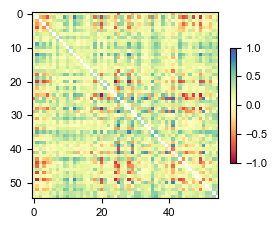

In [14]:
plt.rcParams["figure.figsize"] = (3,3)

hm = plt.imshow (avgSign, cmap='Spectral', vmin=-1,vmax=1)
plt.colorbar (shrink=0.5)
plt.show ()

In [15]:
# enrichment test
Pb, Ptot = compute_enrichment (p_vals, .1, nAA=nAA, symmetric=True)
    
# FDR
fdrps = scipy.stats.false_discovery_control ( Pb[np.triu_indices (npos, k=1)], method='bh' )
thres = np.nanmax (Pb[np.triu_indices (npos, k=1)][fdrps < .1])

# back to matrix
FP = np.zeros_like (Pb)
FP[np.triu_indices (npos, k=1)] = fdrps
FP += np.transpose (FP)
np.fill_diagonal (FP, np.nan)

In [16]:
# BH procedure
fdr_thres = 0.01

# find contacts and nearby things
C5 = np.zeros_like (Df)
C8 = np.zeros_like (Df)

C5[Df <= 5] = 1
C8[np.logical_and (Df > 5, Df <= 8)] = 1

# spectral color map
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-1, 1)

In [17]:
# all simulated folding values for boxplot
foldinglist = list ()
mean_fold = np.zeros (npos)
for i in range (npos) :
    foldinglist.append (En[i*nAA:(i*nAA + nAA),0][~np.isnan (En[i*nAA:(i*nAA + nAA),0])])
    mean_fold[i] = np.nanmean (En[i*nAA:(i*nAA + nAA)])


# t-test for deviation of lambda values from bulk
pvalues_lambda = np.zeros (npos)
for i in range (npos) :
    ddG_i = cp.deepcopy (En[:,0])
    ddG_i[i*nAA:(i*nAA + nAA)] = np.nan
    
    all_gs = ddG_i[~np.isnan (ddG_i)]
    vals_i = cp.deepcopy (En[i*nAA:(i*nAA + nAA),0])
    
    pvalues_lambda[i] = scipy.stats.ttest_ind (all_gs, vals_i[~np.isnan (vals_i)],
                                               equal_var=False, alternative='greater').pvalue
    
# fdr
fdr_lambda = scipy.stats.false_discovery_control (pvalues_lambda[~np.isnan (pvalues_lambda)])
fdr_lambda_thres = np.nanmax (pvalues_lambda[~np.isnan (pvalues_lambda)][fdr_lambda < .1])
print (np.sum (pvalues_lambda < fdr_lambda_thres))

28


In [18]:
xpos = np.arange (2,npos+2,1)

plt.rcParams["figure.figsize"] = (4,3)

# set 0s to minimum value in Pb not equal to 0
Pb_0 = cp.deepcopy (Pb)
Pb_0[Pb == 0] = np.nanmin (Pb[Pb != 0])


fig, axs = plt.subplots (1, 2, width_ratios=[3,1],
                         sharey=False, constrained_layout=True)

# create empty canvas
Cnon = cp.deepcopy (C5)
Cnon[~np.isnan (C5)] = np.nan
axs[0].imshow (Cnon)

# <8A
x, y = np.where ( C8 == 1 )
for i in range (len (x)) :
    axs[0].add_patch( Rectangle((y[i]-.5, x[i]-.5), 1, 1, fill=True,
                            color='lightgray', alpha=0.4, lw=.5))# label=r'$\leq 5\AA$')    
# <5A
x, y = np.where ( C5 == 1 )
for i in range (len (x)) :
    axs[0].add_patch( Rectangle((y[i]-.5, x[i]-.5), 1, 1, fill=True,
                            color='lightgray', lw=.5))# label=r'$\leq 5\AA$')

# fdr .1
x, y = np.where (FP <= fdr_thres)
for i in range (len (x)) :
    x_i = x[i]
    y_i = y[i]
    axs[0].scatter (y_i, x_i, marker='o', edgecolor='black',
                    linewidth=.2, color=spec( norm (avgSign[x_i, y_i])),
                    s=(-np.log10 (Pb_0[x_i,y_i]))**(.75))

# fdr .01
x, y = np.where (np.logical_and (FP > fdr_thres, FP <= .1))
for i in range (len (x)) :
    x_i = x[i]
    y_i = y[i]
    axs[0].scatter (y_i, x_i, marker='o', color=spec( norm (avgSign[x_i, y_i])),
                    linewidth=.2, s=(-np.log10 (Pb_0[x_i,y_i]))**(.75))

# Create the figure
ticklocs   = np.arange (3, npos+1, 5)
axs[0].set_xticks (ticklocs, xpos[ticklocs], fontsize=6)
axs[0].set_yticks (ticklocs, xpos[ticklocs], fontsize=6)
axs[0].tick_params (length=2, labelsize=6, pad=1)

axs[0].set_xlabel (protein + r' position $i$', labelpad=1 )
axs[0].set_ylabel (protein + r' position $i$', labelpad=1 )

bplot = axs[1].boxplot (list (reversed (foldinglist)), 
                        flierprops={'markersize': .25},
                        boxprops={'linewidth': .25},  whiskerprops={'linewidth': .25},
                        capprops={'linewidth': .25}, 
                        patch_artist=True, vert=False)
axs[1].axvline (x=0, linestyle='--', color='gray', linewidth=.5, zorder=0)
axs[1].set_yticks (np.flip (np.arange (2, npos+1, 5)), labels=xpos[np.arange (3,npos,5)],
                   rotation=0, fontsize=6)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].tick_params (length=2, labelsize=6, pad=1)


colors = ['lightgray'] * len (foldinglist)
for i in range (npos) :
    if np.flip (pvalues_lambda)[i] < fdr_lambda_thres :
        colors[i] = 'dimgray'
# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
# Customize the median line
for median in bplot['medians']:
    median.set(color='black', linewidth=.25)

axs[1].set_ylabel ('GB1 position $i$', labelpad=1)
axs[1].set_xlabel (r'$\lambda_i^{fold}$', labelpad=1)
axs[1].set_position([.78, 0.089, 0.15, 0.8975]) 

if save :
    plt.savefig (os.path.join (outdir, 'dij_improved.pdf'), bbox_inches='tight', transparent=True)
    plt.close ()
else :
    plt.show ()